# Testing jraph

In [2]:
from preprocessing_jraph import get_init_crystal_states
import jax
from preprocessing import get_cutoff_mask, get_init_charges, get_gaussian_distance_encodings, v_center_at_atoms_diagonal, type_to_charges_dict, SYMBOL_MAP
from jax import random, numpy as jnp
import optax
import jraph
from typing import Any, Callable, Sequence, Optional, Tuple
import warnings
import numpy as np
import matplotlib.pyplot as plt
import jax.tree_util as tree
import haiku as hk
import pandas as pd
import time

warnings.simplefilter(action='ignore', category=FutureWarning)




In [3]:
def create_implicitly_batched_graphsTuple_with_encoded_distances(descriptors, distances, distances_encoded, init_charges, cutoff_mask, cutoff = 3.0):
    batch_size = descriptors.shape[0]
    natom = descriptors.shape[1]
    # Reshaping the descriptors to go over the whole batch
    descriptors = jnp.reshape(descriptors,(batch_size*natom,descriptors.shape[2]))
    
    # to calculate the number of edges for each individual graph
    distances_flattened_batchwise = jnp.reshape(distances,(batch_size,natom*natom))
    n_edges = jnp.count_nonzero(jnp.logical_and(distances_flattened_batchwise > 0, distances_flattened_batchwise < cutoff),axis=1)
    n_nodes = jnp.repeat(jnp.array([natom]),batch_size)
    # Create a flattened index over all previously diagonal elements to be able to delete them from the flattened arrays.
    flatten_idx = jnp.nonzero(jnp.logical_and(distances.flatten() > 0, distances.flatten() < cutoff))[0]
    idx = jnp.nonzero(jnp.logical_and(distances.flatten() > 0, distances.flatten() < cutoff))[0]
    # Make sure that there are only edges between nodes of the same graph
    # Batch range to add onto the tiled outer products
    batch_range = jnp.reshape(jnp.repeat(jnp.arange(batch_size)*natom,natom*natom),(batch_size,natom,natom))
    # outer product over the atoms
    outer = jnp.tile(jnp.outer(jnp.ones(natom),jnp.arange(natom)).astype(jnp.int32),batch_size).reshape(batch_size,natom,natom)
    # transposed for the other variant
    outer_transposed = jnp.transpose(outer, axes=(0,2,1))
    senders = jnp.add(outer_transposed,batch_range).flatten()[flatten_idx]
    receivers = jnp.add(outer,batch_range).flatten()[flatten_idx]
    sender_descriptors = descriptors[senders,:]
    receiver_descriptors = descriptors[senders,:]
    # Encoded distances are also flattened. Combinations of the same node (diagonal) are deleted
    graph_edges = jnp.reshape(distances_encoded,(distances_encoded.shape[0]*distances_encoded.shape[1]*distances_encoded.shape[2],distances_encoded.shape[3]))[flatten_idx,:]
    # Same for cutoff_mask
    cutoff_mask = cutoff_mask.flatten()[flatten_idx]
    # Nodes contain charges
    # Edges contain concatenation of descriptors, edge_embeddings and cutoff_mask (which will be removed in the Network)
    graph= jraph.GraphsTuple(nodes = init_charges.flatten(),
                            # nodes = jnp.concatenate([descriptors,init_charges],axis=-1), Alternative 
                            senders = senders,
                            receivers = receivers,
                            edges = jnp.concatenate([receiver_descriptors, sender_descriptors, graph_edges, jnp.expand_dims(cutoff_mask,axis=-1)],axis=-1),
                            n_node = n_nodes,
                            n_edge = n_edges,
                            globals = None)
    return graph

#########################################################

def aggregate_edges_for_nodes_fn(edges: jnp.array,
                                receivers: jnp.array,
                                cutoff_mask: jnp.array,
                                n_nodes: int) -> jnp.array:
  edges = jnp.multiply(edges,cutoff_mask)
  return jax.ops.segment_sum(edges,receivers,n_nodes)

def create_model(features, activation):
  if activation == "swish":
    gep_layer = GraphElectronPassing(
      aggregate_edges_for_nodes_fn=aggregate_edges_for_nodes_fn,
      MLP = lambda n: MLP_haiku_swish(features=features)(n),
    )
  else:
    gep_layer = GraphElectronPassing(
      aggregate_edges_for_nodes_fn=aggregate_edges_for_nodes_fn,
      MLP = lambda n: MLP_haiku(features=features)(n),
    )
  return gep_layer


class MLP_haiku(hk.Module):
  def __init__(self, features: jnp.ndarray):
    super().__init__()
    self.features = features

  def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
    layers = []
    for feat in self.features[:-1]:
      layers.append(hk.Linear(feat))
      layers.append(jax.nn.relu)
    layers.append(hk.Linear(self.features[-1]))
    mlp = hk.Sequential(layers)
    return mlp(x)

class MLP_haiku_swish(hk.Module):
  def __init__(self, features: jnp.ndarray):
    super().__init__()
    self.features = features

  def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
    layers = []
    for feat in self.features[:-1]:
      layers.append(hk.Linear(feat))
      layers.append(jax.nn.swish)
    layers.append(hk.Linear(self.features[-1]))
    mlp = hk.Sequential(layers)
    return mlp(x)

# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/_src/models.py#L506
def GraphElectronPassing(aggregate_edges_for_nodes_fn: Callable,
                        MLP: Callable,
                        h_dim: int = 126) -> Callable:
  """
  Args:
    update_node_fn: function used to update the nodes. In the paper a single
      layer MLP is used.
    aggregate_edges_for_nodes_fn: function used to aggregates the sender nodes.

  Returns:
    A method that applies a Graph Convolution layer.
  """

  def _ApplyGEP(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Applies a Graph Convolution layer."""
    nodes, edges, receivers, senders, _, _, _ = graph
    receiver_descriptors = edges[:,:h_dim]
    sender_descriptors=edges[:,h_dim:h_dim*2]
    graph_edges = edges[:,h_dim*2:-1]
    cutoff_mask = jnp.expand_dims(edges[:,-1],axis=-1)
    sender_charges = jnp.expand_dims(nodes[senders],axis=-1)
    receiver_charges = jnp.expand_dims(nodes[receivers],axis=-1)
    # Neural network forward: NN(q_v, q_w, h_v, h_w, e_vw) from the paper
    edges = jnp.concatenate([receiver_charges, sender_charges, receiver_descriptors, sender_descriptors, edges],axis=-1)
    edges_reversed = jnp.concatenate([sender_charges, receiver_charges, sender_descriptors, receiver_descriptors, edges],axis=-1)
    # Subtraction of both outputs to create electron-passing-output for atom v
    MLP_outputs = jnp.subtract(MLP(edges),MLP(edges_reversed))
    # aggregate_edges_for_nodes_fn is the weighting function with the cutoff_mask
    received_attributes = tree.tree_map(
      lambda e: aggregate_edges_for_nodes_fn(e, receivers, cutoff_mask, nodes.shape[0]), MLP_outputs)
    nodes = received_attributes.flatten()
    return graph._replace(nodes=nodes)
  return _ApplyGEP

In [4]:
# def print_graph_stats(graph):
#     print("Nodes-Shape:",graph[0].shape)
#     print("Edges-Shape:",graph[1].shape)
#     print("Senders-Length:",graph[2].shape)
#     print("Globals:",None if graph[4] is None else graph[4].shape)
#     print("n_nodes:",graph[5])
#     print("n_edges:",graph[6])

# print_graph_stats(train_batches[0])

In [5]:
# plt.boxplot(np.array(distances.flatten()))

In [6]:

  # except: 
  #   result_table = result_table.set_index(["e_dim","r_switch","r_cut","distance_encoding_type","features","num_passes","activation_fn","n_epochs"])


In [7]:
def run_model_with_hyperparameters(E_DIM : int,
                                  R_SWITCH : float,
                                  R_CUT : float,
                                  DISTANCE_ENCODING_TYPE : str,
                                  FEATURES : list,
                                  NUM_PASSES : int,
                                  ACTIVATION : str,
                                  N_EPOCHS : int
                                  ):
    CURRENT_INDEX = (E_DIM, R_SWITCH, R_CUT, DISTANCE_ENCODING_TYPE, str(FEATURES), NUM_PASSES, ACTIVATION, N_EPOCHS)

    ######## Results ###############
    result_table = pd.read_csv("results/result_table.csv").set_index(["e_dim","r_switch","r_cut","distance_encoding_type","features","num_passes","activation_fn","n_epochs"])
    if result_table.index.isin([CURRENT_INDEX]).any():
        print("Results already in Dataframe.")
    else:
        step_list = []
        rmse_list_val = []


        #################################################
        #################################################
        print("Start training.")
        print("Current Parameter-Setting:",CURRENT_INDEX)
        ct = time.time()
        best_val_rmse = np.inf
        for i in range(N_EPOCHS):
            rmse_batch_train_losses = []
            for batch_no in range(len(train_batches)):
                params, opt_state = update(train_batches[batch_no],true_labels[batch_no], params, opt_state)
            for batch_no in range(len(train_batches)):
                rmse_batch_train_losses.append(rmse_loss(params, train_batches[batch_no],true_labels[batch_no]))
            val_rmse = float(rmse_loss(params, val_batch, true_labels_val))
            if val_rmse < best_val_rmse:
                best_val_rmse = val_rmse
            if (i % 10)==0:
                step_list.append(i)
                rmse_list_val.append(val_rmse)
                print("Epoch:",i,"-  Train-RMSE:", round(float(sum(rmse_batch_train_losses)/len(rmse_batch_train_losses)),5)," -  Val-RMSE:", round(val_rmse,5))
        time_taken = round((time.time()-ct)/60,2)
        test_rmse = rmse_loss(params, test_batch, true_labels_test)
        test_mae = mae_loss(params, test_batch, true_labels_test)

        if result_table.index.isin([CURRENT_INDEX]).any():
            result_table.loc[CURRENT_INDEX] = time_taken, test_rmse, test_mae, list(step_list), list(rmse_list_val)
        else:
            result_table = result_table.reset_index().append(dict(zip(["e_dim","r_switch","r_cut","distance_encoding_type","features","num_passes","activation_fn","n_epochs","time_needed","test_rmse","test_mae","steps","val_rmses", "best_val_rmse"],[E_DIM, R_SWITCH, R_CUT, DISTANCE_ENCODING_TYPE, str(FEATURES), NUM_PASSES, ACTIVATION, N_EPOCHS, time_taken, test_rmse, test_mae, list(step_list), list(rmse_list_val), best_val_rmse])), ignore_index = True).set_index(["e_dim","r_switch","r_cut","distance_encoding_type","features","num_passes","activation_fn","n_epochs"])

        print("Best-Val-RMSE:",best_val_rmse)
        result_table.to_csv("results/result_table.csv")

In [8]:
import gc
gridsearch_dict = {
    "e_dim":[6,12,24,48,96],
    "r_switch":[0.1, 0.5, 1.0, 2.0],
    "r_cut":[1.0,2.0,5.0,10.0],
    "r_switch_cut" : [(0.1,1.0),(0.5,2.0),(1.0,5.0),(2.0,10.0),(0.5,10.0),(0.1,5.0),(1.0,2.0),(0.1,15.0),(0.1,20.0),(0.1,10.0)],
    "distance_encoding_type": ["none"],
    "features":[[32,32,1],[32,32,32,1],[64,32,1],[16,16,16,16,16,1],[64,32,16,8,4,1],[64,64,1],[64,32,32,1]],
    # "num_passes":[1,2,3,4,5],
    "num_passes":[3],
    "activation":["relu","switch"],
}
############### Example loops ###################
# for E_DIM in gridsearch_dict["e_dim"]:
# # for R_SWITCH in gridsearch_dict["r_switch"]:
# for R_SWITCH, R_CUT in gridsearch_dict["r_switch_cut"]:
# for DISTANCE_ENCODING_TYPE in gridsearch_dict["distance_encoding_type"]:
# for FEATURES in gridsearch_dict["features"]:
# for NUM_PASSES in gridsearch_dict["num_passes"]:
# for ACTIVATION in gridsearch_dict["activation"]:


#######################################
###### HYPERPARAMETERS ################
E_DIM = 36
R_SWITCH = 0.5
R_CUT = 10.0
DISTANCE_ENCODING_TYPE = "none"
FEATURES = [64,32,16,8,1]
# FEATURES = [128,64,32,1]
NUM_PASSES = 3
ACTIVATION = "relu"
N_EPOCHS = 800


#######################################
## loading input values from file #####

key, subkey = random.split(random.PRNGKey(0))
h_dim = 126
path = "data/SrTiO3_500.db"
descriptors, distances, distances_encoded, init_charges, gt_charges, cutoff_mask, types = get_init_crystal_states(path, edge_encoding_dim = E_DIM, SAMPLE_SIZE = None, r_switch = R_SWITCH, r_cut = R_CUT, distance_encoding_type = DISTANCE_ENCODING_TYPE) # Change sample size to None if all samples should be read.

#######################################
### Creating batches for training #####

total_size = descriptors.shape[0]
train_batch_size = 50
test_size = 50
val_size = 50
train_size = total_size - test_size - val_size
key = random.PRNGKey(0)
permuted_idx = random.permutation(key, jnp.arange(500))
test_idx = permuted_idx[-test_size:]
val_idx = permuted_idx[-2*test_size:-test_size]
train_idxs = jnp.array(jnp.split(permuted_idx[:-2*test_size],int(jnp.ceil(train_size/train_batch_size))))
train_batches = [create_implicitly_batched_graphsTuple_with_encoded_distances(descriptors[train_idx],distances[train_idx], distances_encoded[train_idx],init_charges[train_idx],cutoff_mask[train_idx]) for train_idx in train_idxs]
val_batch = create_implicitly_batched_graphsTuple_with_encoded_distances(descriptors[val_idx],distances[val_idx], distances_encoded[val_idx],init_charges[val_idx],cutoff_mask[val_idx])
test_batch = create_implicitly_batched_graphsTuple_with_encoded_distances(descriptors[test_idx],distances[test_idx], distances_encoded[test_idx],init_charges[test_idx],cutoff_mask[test_idx])

for DISTANCE_ENCODING_TYPE in gridsearch_dict["distance_encoding_type"]:
    gep_layer = create_model(FEATURES,ACTIVATION)
    ################################
    model = hk.without_apply_rng(hk.transform(gep_layer))
    params = model.init(jax.random.PRNGKey(42), train_batches[0])
    true_labels = [gt_charges[train_idx].flatten() for train_idx in train_idxs]
    true_labels_val = gt_charges[val_idx].flatten()
    true_labels_test = gt_charges[test_idx].flatten()
    opt_init, opt_update = optax.adam(1e-2)
    opt_state = opt_init(params)

    # Create loss functions with correct NUM_PASSES and model
    @jax.jit
    def rmse_loss(params: hk.Params, graph: jraph.GraphsTuple,  ground_truth: jnp.array) -> jnp.ndarray:
        # hk.fori_loop(0,3, model.apply, graph, params=params)
        output = model.apply(params, graph)
        print(NUM_PASSES)
        for i in range(NUM_PASSES-1):
          output = model.apply(params, output)
        return jnp.sqrt(jnp.sum(jnp.square(output[0]-ground_truth)/len(ground_truth)))

    @jax.jit
    def mae_loss(params: hk.Params, graph: jraph.GraphsTuple,  ground_truth: jnp.array) -> jnp.ndarray:
        # hk.fori_loop(0,3, model.apply, graph, params=params)
        output = model.apply(params, graph)
        for i in range(NUM_PASSES-1):
          output = model.apply(params, output)
        return jnp.sum(jnp.abs(output[0]-ground_truth)/len(ground_truth))

    @jax.jit
    def update(train_batch: jraph.GraphsTuple, true_labels:jnp.array, params: hk.Params, opt_state) -> Tuple[hk.Params, Any]:
        """Returns updated params and state."""
        g = jax.grad(rmse_loss)(params, train_batch, true_labels)
        updates, opt_state = opt_update(g, opt_state)
        return optax.apply_updates(params, updates), opt_state



    CURRENT_INDEX = (E_DIM, R_SWITCH, R_CUT, DISTANCE_ENCODING_TYPE, str(FEATURES), NUM_PASSES, ACTIVATION, N_EPOCHS)
    result_table = pd.read_csv("results/result_table.csv").set_index(["e_dim","r_switch","r_cut","distance_encoding_type","features","num_passes","activation_fn","n_epochs"])
    if result_table.index.isin([CURRENT_INDEX]).any():
        print("Results already in Dataframe.")
    else:
        ######## Results ###############
        result_table = pd.read_csv("results/result_table.csv").set_index(["e_dim","r_switch","r_cut","distance_encoding_type","features","num_passes","activation_fn","n_epochs"])
        if result_table.index.isin([CURRENT_INDEX]).any():
            print("Results already in Dataframe.")
        else:
            step_list = []
            rmse_list_val = []
            #################################################
            #################################################
            print("Start training.")
            print("Current Parameter-Setting:",CURRENT_INDEX)
            ct = time.time()
            best_val_rmse = np.inf
            best_model = None
            for i in range(N_EPOCHS):
                rmse_batch_train_losses = []
                for batch_no in range(len(train_batches)):
                    params, opt_state = update(train_batches[batch_no],true_labels[batch_no], params, opt_state)
                for batch_no in range(len(train_batches)):
                    rmse_batch_train_losses.append(rmse_loss(params, train_batches[batch_no],true_labels[batch_no]))
                val_rmse = float(rmse_loss(params, val_batch, true_labels_val))
                if val_rmse < best_val_rmse:
                    best_val_rmse = val_rmse
                    best_model = model
                if (i % 10)==0:
                    step_list.append(i)
                    rmse_list_val.append(val_rmse)
                    print("Epoch:",i,"-  Train-RMSE:", round(float(sum(rmse_batch_train_losses)/len(rmse_batch_train_losses)),5)," -  Val-RMSE:", round(val_rmse,5))
            time_taken = round((time.time()-ct)/60,2)
            test_rmse = rmse_loss(params, test_batch, true_labels_test)
            test_mae = mae_loss(params, test_batch, true_labels_test)

            if result_table.index.isin([CURRENT_INDEX]).any():
                result_table.loc[CURRENT_INDEX] = time_taken, test_rmse, test_mae, list(step_list), list(rmse_list_val)
            else:
                result_table = result_table.reset_index().append(dict(zip(["e_dim","r_switch","r_cut","distance_encoding_type","features","num_passes","activation_fn","n_epochs","time_needed","test_rmse","test_mae","steps","val_rmses", "best_val_rmse"],[E_DIM, R_SWITCH, R_CUT, DISTANCE_ENCODING_TYPE, str(FEATURES), NUM_PASSES, ACTIVATION, N_EPOCHS, time_taken, test_rmse, test_mae, list(step_list), list(rmse_list_val), best_val_rmse])), ignore_index = True).set_index(["e_dim","r_switch","r_cut","distance_encoding_type","features","num_passes","activation_fn","n_epochs"])

            print("Best-Val-RMSE:",best_val_rmse)
            result_table.to_csv("results/result_table.csv")

  0%|          | 0/500 [00:00<?, ?it/s]

Start training.
Current Parameter-Setting: (36, 0.5, 10.0, 'none', '[64, 32, 16, 8, 1]', 3, 'relu', 800)
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
Epoch: 0 -  Train-RMSE: 1.08411  -  Val-RMSE: 1.08532
Epoch: 10 -  Train-RMSE: 0.21393  -  Val-RMSE: 0.21555
Epoch: 20 -  Train-RMSE: 0.08769  -  Val-RMSE: 0.09333
Epoch: 30 -  Train-RMSE: 0.09469  -  Val-RMSE: 0.09825
Epoch: 40 -  Train-RMSE: 0.05957  -  Val-RMSE: 0.06492
Epoch: 50 -  Train-RMSE: 0.10059  -  Val-RMSE: 0.10397
Epoch: 60 -  Train-RMSE: 0.078  -  Val-RMSE: 0.08305
Epoch: 70 -  Train-RMSE: 0.07425  -  Val-RMSE: 0.0793
Epoch: 80 -  Train-RMSE: 0.05582  -  Val-RMSE: 0.06118
Epoch: 90 -  Train-RMSE: 0.05485  -  Val-RMSE: 0.05976
Epoch: 100 -  Train-RMSE: 0.04583  -  Val-RMSE: 0.05028
Epoch: 110 -  Train-RMSE: 0.03958  -  Val-RMSE: 0.04467
Epoch: 120 -  Train-RMSE: 0.04168  -  Val-RMSE: 0.04673
Epoch: 130 -  Train-RMSE: 0.03719  -  Val-RMSE: 0.04265
Epoch: 140 -  Train-RMSE: 0.0366  -  Val-RMSE: 0.04169
Epoch: 150 -  Train-RMSE: 0.03992  -

0.024786495


Text(0, 0.5, 'actual charges')

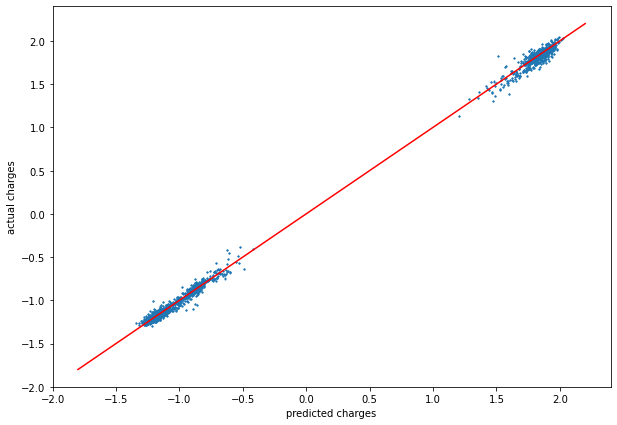

In [9]:
test_mae = mae_loss(params, test_batch, true_labels_test)
print(test_mae)
output = best_model.apply(params, test_batch)
for i in range(NUM_PASSES-1):
    output = model.apply(params, output)


plt.rcParams["figure.figsize"] = (10,7)
plt.plot(output[0],true_labels_test,".",ms=2)
plt.plot([-1.8,2.2],[-1.8,2.2],color="red", ms=0.5)
plt.xlabel("predicted charges")
plt.ylabel("actual charges")


In [10]:
result_table = pd.read_csv("results/result_table.csv").set_index(["e_dim","r_switch","r_cut","distance_encoding_type","features","num_passes","activation_fn","n_epochs"])
CURRENT_INDEX = (E_DIM, R_SWITCH, R_CUT, "ROOT", str(FEATURES), NUM_PASSES, ACTIVATION, N_EPOCHS)
# print(CURRENT_INDEX)
# result_table.loc[CURRENT_INDEX]["best_val_rmse"]
result_table.sort_values(by="best_val_rmse").index[0]

(36, 0.5, 10.0, 'none', '[64, 32, 16, 8, 1]', 3, 'relu', 800)

In [11]:
# def create_graphsTuple_with_encoded_distances(descriptors, distances, distances_encoded, init_charges, cutoff_mask, cutoff = R_CUT):
#     natom = descriptors.shape[0]
#     # Create a flattened index over all previously diagonal elements to be able to delete them from the flattened arrays. 
#     flatten_idx = jnp.nonzero(jnp.logical_and(distances > 0, distances < cutoff).flatten())[0]
#     senders = jnp.outer(jnp.ones(natom),jnp.arange(natom)).T.flatten()[flatten_idx].astype(jnp.int32)
#     receivers = jnp.outer(jnp.ones(natom),jnp.arange(natom)).flatten()[flatten_idx].astype(jnp.int32)
#     sender_descriptors = descriptors[senders,:]
#     # print(senders,receivers)
#     receiver_descriptors = descriptors[senders,:]
#     n_nodes = jnp.array([natom])
#     n_edges = jnp.array([natom*natom-natom])
#     # Encoded distances are also flattened. Combinations of the same node (diagonal) are deleted
#     graph_edges = jnp.reshape(distances_encoded,(distances_encoded.shape[0]*distances_encoded.shape[1],48))[flatten_idx,:]
#     # Same for cutoff_mask
#     cutoff_mask = cutoff_mask.flatten()[flatten_idx]
#     # Nodes contain charges
#     # Edges contain concatenation of descriptors, edge_embeddings and cutoff_mask (which will be removed in the Network)
#     graph= jraph.GraphsTuple(nodes = init_charges,
#                             # nodes = jnp.concatenate([descriptors,init_charges],axis=-1), Alternative 
#                             senders = senders,
#                             receivers = receivers,
#                             edges = jnp.concatenate([receiver_descriptors, sender_descriptors, graph_edges, jnp.expand_dims(cutoff_mask,axis=-1)],axis=-1),
#                             n_node = n_nodes,
#                             n_edge = n_edges,
#                             globals = None)
#     return graph

# graph = create_graphsTuple_with_encoded_distances(descriptors[0],distances[0], distances_encoded[0],init_charges[0],cutoff_mask[0])

In [12]:
# natom = 4
# batch_size = 2

# batch_range = jnp.reshape(jnp.repeat(jnp.arange(batch_size)*natom,natom*natom),(batch_size,natom,natom))
# outer = jnp.tile(jnp.outer(jnp.ones(natom),jnp.arange(natom)).astype(jnp.int32),batch_size).reshape(batch_size,natom,natom)
# outer_transposed = jnp.transpose(outer, axes=(0,2,1))
# senders = jnp.add(outer_transposed,batch_range).flatten()
# receivers = jnp.add(outer,batch_range).flatten()

# senders, receivers